# Assignment 4 - NLP Disaster Tweets Kaggle Mini Project

## Description

This project is a binary text classification. The goal of this project is to develop a recurring nueral network model that can accurately identify Tweets whose content relates to a real disaster from those that do not. The data is provided by the Kaggle Natural Language Processing with Disaster Tweets Competition and located at https://www.kaggle.com/c/nlp-getting-started/overview.


## Data Summary
The data consists of training and test data.  The train.csv file contains the training data comprised of an id, keyword, location, Tweet text and ground truth labels. There are 7613 rows in the training data.  The test.csv file contains the test data comprised of an id, keyword, location, Tweet text, however it does not include a label. There are 3263 rows in the test data. The sample_submission.csv contains the ids of the test Tweets and sampleground truth labels. The labeles are to be replaced with test results and submitted for assessment of the model.

In [16]:
!pip install pandas emoji
!pip install nltk

In [1]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
#Load Required Resources

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import models
from tensorflow.python.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Embedding
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam

In [3]:
## Import Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv ")

print(train_df.head(), '\n')
print(train_df.info(), '\n')
print('Train Shape: ', train_df.shape, '\n')
print(test_df.head(), '\n')
print(test_df.info())
print('Test Shape: ', test_df.shape, '\n')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

Train Shape:  (7613, 5) 

   id 

### EDA

EDA will be performed as follows:

    1. Remove unnecessary columns (keyword and location)
    2. Check for NaNs and Nulls in remaining columns
    3. Understand distributions of data sets
    4. Cleanse test strings
        - Remove Punctuation
        - Remove Stop Words
        - Remove Hyperlinks
        - Convert to all lower case
    
Columns keyword and location are irrelevent to the analysis and therefore removed from the data sets.

**Drop keyword and location**

In [4]:
# drop key and location 

train_df = train_df.drop(['keyword', 'location'], axis=1)
test_df = test_df.drop(['keyword', 'location'], axis=1)

print(train_df.head(), '\n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1 

   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


**Check for Nulls**

In [5]:
#Check for NaNs and Nulls
print('Train id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Test id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')

Train id NaNs / Null Count:  0 

Test id NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 



**Label Distributions**

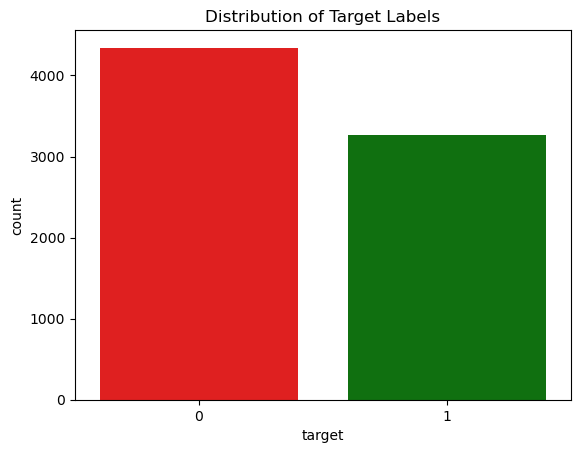

0 Label:  4342
1 Label:  3271


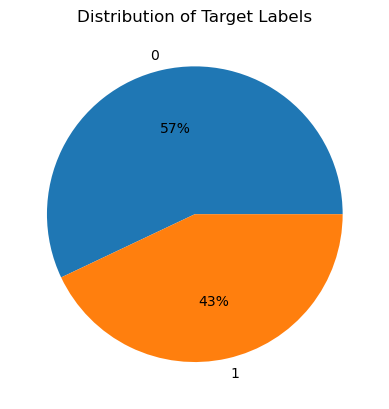

In [6]:
plt.figure()
sns.countplot(data=train_df, x='target', palette=['#ff0000',"#008000"])
plt.title('Distribution of Target Labels')
plt.show()

target_0 = train_df["target"].value_counts()[0]
target_1 = train_df["target"].value_counts()[1]
print('0 Label: ', target_0)
print('1 Label: ', target_1)

plt.figure()
plt.pie([target_0, target_1], labels=[0,1], autopct='%.0f%%')
plt.title('Distribution of Target Labels')
plt.show()


### Cleanse Data

**Remove Hyperlinks**

In [7]:
import re

print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))
test_df['text'] = test_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))

print('After')
print(train_df['text'][31])
print(test_df['text'][32])


Before
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... http://t.co/kKFaSJv6Cj
After
@bbcmtd Wholesale Markets ablaze 
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... 


**Remove Punctuation**

In [8]:
train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')
print(train_df.head(), '/n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this earthquake Ma...       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked to shelter in place are be...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent this photo from Ruby Alaska as s...       1 /n
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about earthquake is different cities sta...
2   3  there is a forest fire at spot pond geese are ...
3   9              Apocalypse lighting Spokane wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_21960\2543514056.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_21960\2543514056.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')


**Remove Stop Words**

In [9]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
  
stop_words = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(train_df.head(), '/n')
print(test_df.head())


   id                                               text  target
0   1   Our Deeds Reason earthquake May ALLAH Forgive us       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked shelter place notified off...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent photo Ruby Alaska smoke wildfire...       1 /n
   id                                               text
0   0                   Just happened terrible car crash
1   2  Heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              Apocalypse lighting Spokane wildfires
4  11             Typhoon Soudelor kills 28 China Taiwan


**Convert to all lower case**

In [10]:
print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  x.lower())
test_df['text'] = test_df['text'].apply(lambda x:  x.lower())

print('After')
print(train_df['text'][31])
print(test_df['text'][32])

Before
bbcmtd Wholesale Markets ablaze
3 Car Recorder ZeroEdgeå Duallens Car Camera Vehicle TrafficDriving HistoryAccident Camcorder Large Re
After
bbcmtd wholesale markets ablaze
3 car recorder zeroedgeå duallens car camera vehicle trafficdriving historyaccident camcorder large re


### Models

#### LSTM Model

In [ ]:
#Split the training data
x_training_set, x_validation_set, target_train, target_validation= train_test_split(train_df['text'].values, train_df['target'].values, random_state=25, test_size=0.3, shuffle=True)


max_length_text = train_df.text.map(len).max()
print('Maximum Text Length: ', max_length_text)
dict_size = 15000
embedding_size = 64
#Set Up tokenizer

tokenizer = text.Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(x_training_set)

word_index = tokenizer.word_index

sequence_x_training_set = tokenizer.texts_to_sequences(x_training_set)
sequence_x_validation_set = tokenizer.texts_to_sequences(x_validation_set)
sequence_x_validation_set = tokenizer.texts_to_sequences(test_df['text'].values)

sequence_x_training_set_padded = sequence.pad_sequences(sequence_x_training_set, maxlen=max_length_text)
sequence_x_validation_set_padded = sequence.pad_sequences(sequence_x_validation_set, maxlen=max_length_text)
sequence_x_test_set_padded = sequence.pad_sequences(sequence_x_test_set, maxlen=max_length_text)

print('Sample: ', sequence_x_training_set_padded[0])

# target_tokenizer = text.Tokenizer()
# target_tokenizer.fit_on_texts(target_train)

# training_target_seq = np.array(target_tokenizer.texts_to_sequences(target_train))
# validation_target_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))


# model = tf.keras.Sequential([
#     # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
#     tf.keras.layers.Embedding(15000, 64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
# #    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     # use ReLU in place of tanh function since they are very good alternatives of each other.
#     tf.keras.layers.Dense(embedding_dim, activation='relu'),
#     # Add a Dense layer with 6 units and softmax activation.
#     # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
#     before_model.add(Dense(1))
#     before_model.add(Activation('sigmoid'))
# ])
#Hyperparameter Tuning variables
dropout_rate = .2
recurrent_dropout_rate = .2
num_epochs = 2

model = Sequential()

model.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
model.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model.add(Dense(embedding_size, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)

model.save_weights(model_weight_file.h5)


target_test = model.predict(sequence_x_test_set_padded)
target_test

# #Test model
# scores = model.evaluate(sequence_x_test_set_padded, Y_test, verbose=0, batch_size=batch_size)


# print("Acc: %.2f%%" % (scores[1] * 100))

Maximum Text Length:  139
Sample:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 3519 1057 5398  968  969  239  373 3520 2660]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 139, 64)           960000    
_______________________________________

### References

Remove Stop Words from Text in DataFrame Column, https://www.datasnips.com/58/remove-stop-words-from-text-in-dataframe-column/

How to Remove URLs from Text in Python, https://bobbyhadz.com/blog/python-remove-url-from-text